In [1]:
!pip install transformers
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import os
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

In [3]:
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

In [4]:
model = tf.keras.models.load_model(r"C:\Users\TKA\Desktop\Project_cs210\trained_model")

In [5]:
#use pretrained model to label data
def model_predict(text_list, name):

    # Tokenize the input sentences
    tf_batch = tokenizer(text_list, max_length=128, padding=True, truncation=True, return_tensors='tf')

    # Make predictions
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs['logits'], axis=-1)
    labels = ['Negative', 'Positive']
    predicted_labels = tf.argmax(tf_predictions, axis=1).numpy()

    # Create a new DataFrame with the text value and predicted value
    results_df = pd.DataFrame({'Name' : name, 'Text': text_list, 'Predicted Value': predicted_labels})
    results_df['Predicted Value'] = results_df['Predicted Value'].map(lambda x: labels[x])

    return results_df

In [6]:
# model prediction for every key in dictionary
def model_predict_dict(name_dict):

    frames = []
    for name in name_dict.keys():
        frames.append(model_predict(name_dict[name], name))

    return pd.concat(frames)

In [7]:
#extracts text from every .txt file in that directory
def extract_text_from_directory(dir_path):
    print(dir_path)
    text_list = []
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)

        with open(file_path, "r") as f:
            text_list.append(f.read())
    return text_list

In [8]:

ROOT_PATH = r"C:\Users\TKA\Desktop\Project_cs210"

pos_akbank    = extract_text_from_directory(os.path.join(ROOT_PATH, "pos_akbank"))
pos_gedik     = extract_text_from_directory(os.path.join(ROOT_PATH, "pos_gedik"))
pos_garanti   = extract_text_from_directory(os.path.join(ROOT_PATH, "pos_garanti"))
pos_yapikredi = extract_text_from_directory(os.path.join(ROOT_PATH, "pos_yapikredi"))
neg_akbank    = extract_text_from_directory(os.path.join(ROOT_PATH, "neg_akbank"))
neg_gedik     = extract_text_from_directory(os.path.join(ROOT_PATH, "neg_gedik"))
neg_garanti   = extract_text_from_directory(os.path.join(ROOT_PATH, "neg_garanti"))
neg_yapikredi = extract_text_from_directory(os.path.join(ROOT_PATH, "neg_yapikredi"))

pos_dict = {"akbank": pos_akbank, "gedik" : pos_gedik, "garanti" : pos_garanti, "yapikredi" : pos_yapikredi}
neg_dict = {"akbank": neg_akbank, "gedik" : neg_gedik, "garanti" : neg_garanti, "yapikredi" : neg_yapikredi}
# print(pos_dict)
# print(neg_dict)

C:\Users\TKA\Desktop\Project_cs210\pos_akbank
C:\Users\TKA\Desktop\Project_cs210\pos_gedik
C:\Users\TKA\Desktop\Project_cs210\pos_garanti
C:\Users\TKA\Desktop\Project_cs210\pos_yapikredi
C:\Users\TKA\Desktop\Project_cs210\neg_akbank
C:\Users\TKA\Desktop\Project_cs210\neg_gedik
C:\Users\TKA\Desktop\Project_cs210\neg_garanti
C:\Users\TKA\Desktop\Project_cs210\neg_yapikredi


In [9]:
#predict with the trained model and tranform it into a dataframe
frames = [model_predict_dict(pos_dict), model_predict_dict(neg_dict)]

In [10]:
df = pd.concat(frames)
# df

In [11]:
df_grouped = df.groupby(['Name', 'Predicted Value'])
df_grouped.describe()

Text         \
                          count unique   
Name      Predicted Value                
akbank    Negative          347    339   
          Positive          231    229   
garanti   Negative          117     87   
          Positive          149     59   
gedik     Negative           81     81   
          Positive           69     69   
yapikredi Negative          149    148   
          Positive          336    331   

                                                                              \
                                                                         top   
Name      Predicted Value                                                      
akbank    Negative         BIST-100 geçtiğimiz haftayı %1 civarı artışla ...   
          Positive         BIST-100 dün yukarı yönlü açılışın ardından ye...   
garanti   Negative         Düşük küresel risk iştahı BİST'te sıkışık eğil...   
          Positive         ABD'de dün açıklanan TÜFE verisinin ardından s...   
gedik     Negative         Haftaya güç kazanan alımlarla başlayan ve 5.00...   
          Positive         BIST-100 Endeksi’nde geçen haftanın ardından b...   
yapikredi Negative         2350 desteği önemini koruyor... Endekste 2,350...   
          Positive         Kısa vadeli teknik resmi incelediğimizde, gene...   

                                
                          freq  
Name      Predicted Value       
akbank    Negative           2  
          Positive           2  
garanti   Negative          16  
          Positive          16  
gedik     Negative           1  
          Positive           1  
yapikredi Negative           2  
          Positive           2

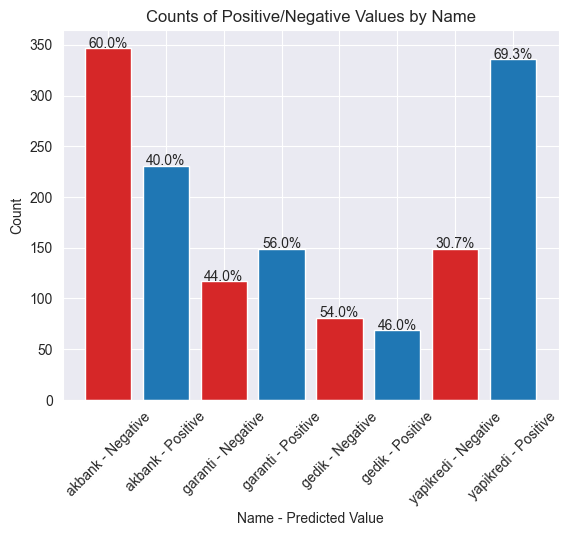

In [12]:
total_size = []
s = df_grouped.size().tolist()

# negative+positive Text count for every name
for i in range(0, len(s), 2):
    if i + 1 < len(s):
        sum_pair = s[i] + s[i + 1]
        total_size.append(sum_pair)


# Create a figure and axis for the bar graph
fig, ax = plt.subplots()

# color scheme
palette_tab10 = sns.color_palette("tab10", 10)
palette = sns.color_palette([palette_tab10[3], palette_tab10[0]])

# Iterate over the groups and plot the bar graph
num = 0
for (name, label), group_df in df_grouped:

    # number of labels specific to that name
    n_size = df_grouped.size().tolist()[num]

    # Count the number of rows in each group
    count = len(group_df)

    # Calculate the percentage for the count within the group
    percentage = n_size*100/total_size[num // 2]

    # Plot a bar with the count, using the corresponding color
    ax.bar(f"{name} - {label}", count, color=palette[num % 2])

    # Annotate the bar with the percentage value
    ax.text(f"{name} - {label}", count + 0.5, f"{percentage:.1f}%", ha='center')
    num = num+1

# Set the labels and title
ax.set_xlabel('Name - Predicted Value')
ax.set_ylabel('Count')
ax.set_title('Counts of Positive/Negative Values by Name')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Show the bar graph
plt.show()